## In-depth  energy module behaviour
In this notebook, we set up graph with a single edge to demonstrate some basic functionality of the Energy module.

#### 0. Import libraries

In [24]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
import pyproj
from pyproj import Geod
import shapely.geometry
from shapely.geometry import Point, LineString
from shapely.geometry.base import BaseGeometry

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
from opentnsim import core as core_module
from opentnsim.energy import mixins as energy_module
from opentnsim import graph as graph_module
from opentnsim import output as output_module
from opentnsim.core import vessel_properties as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module


# package(s) needed for inspecting the output
import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("This notebook is executed with OpenTNSim version {}".format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.3.7


#### 1. Define object classes

In [25]:
# make your preferred Vessel class out of available mix-ins.
Vessel = type(
    "Vessel", 
    (
        opentnsim.energy.mixins.ConsumesEnergy,
        opentnsim.core.Identifiable,                       # allows to give the object a name and a random ID,
        opentnsim.core.Movable,                            # allows the object to move, with a fixed speed, while logging this activity
        opentnsim.core.vessel_properties.VesselProperties,
        opentnsim.core.ExtraMetadata,
    ), 
    {}
)

#### 2. Create graph
Next we create a network (a graph) along which the vessel can move. This case we create a single edge of 100 km exactly.

In [26]:
# initialize geodetic calculator with WGS84 ellipsoid
geod = Geod(ellps="WGS84")

In [27]:
# starting point (longitude, latitude)
lon0, lat0 = 0, 0

# compute the other point 100 km East from Point 0
lon1, lat1, _ = geod.fwd(lon0, lat0, 90, 100000) # East from Point 0

# define nodes with their geographic coordinates
coords = {
    "0": (lon0, lat0),
    "1": (lon1, lat1),
}

In [28]:
# create list of edges
edges = [("0", "1"), ("1", "0")] # bi-directional edge

In [29]:
# create a directed graph
FG = nx.DiGraph()

# add nodes
for name, coord in coords.items():
    FG.add_node(name, geometry=Point(coord[0], coord[1]))

# add edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], weight=1)

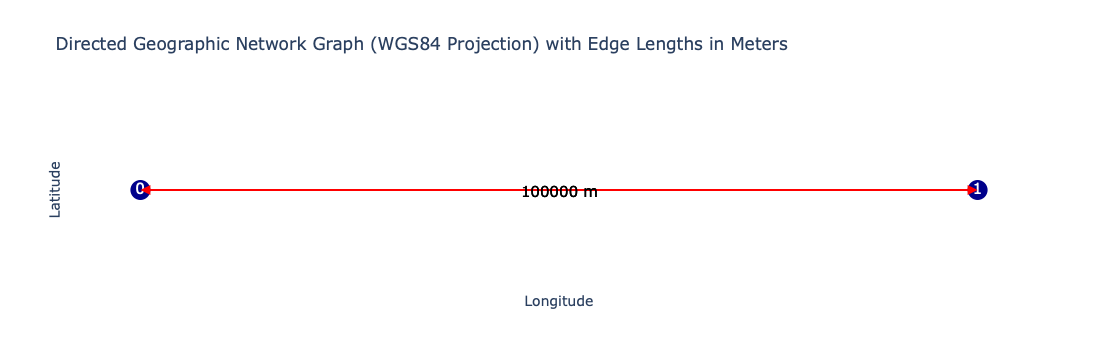

In [30]:
opentnsim.graph.plot_graph(FG)

#### 3. Run simulation

In [31]:
def mission(FG, GeneralDepth, 
            name, origin, destination, vessel_type, L, B, T, v, safety_margin, 
            h_squat, P_installed, P_tot_given, bulbous_bow, karpov_correction, P_hotel_perc, P_hotel, x, L_w, C_B,  
            C_year, arrival_time):
    """Method that defines the mission of the vessel. 
    
    In this case: 
        a basic vessel moves along the given route
    """

    # start simpy environment
    simulation_start = datetime.datetime(2024, 1, 1, 0, 0, 0)
    env = simpy.Environment(initial_time=simulation_start.timestamp())
    env.epoch = simulation_start# Start simpy environment

    # add graph to environment 
    FG.edges['0', '1']['Info'] = {'GeneralDepth': GeneralDepth}
    FG.edges['1', '0']['Info'] = {'GeneralDepth': GeneralDepth}
    env.graph = FG

    #TODO: make a mission with all inputs (now some are
    vessel = Vessel(**{ "env": env,
                        "name": name,
                        "origin": origin,
                        "destination": destination,
                        "type": vessel_type,
                        "L": L,                         # m
                        "B": B,                         # m
                        "T": T,                         # m
                        "v": v,                         # m/s None: calculate this value based on P_tot_given
                        "safety_margin": safety_margin, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                        "h_squat": h_squat,             # if consider the ship squatting while moving, set to True, otherwise set to False
                        "P_installed": P_installed,     # kW
                        "P_tot_given": P_tot_given,     # kW None: calculate this value based on speed
                        "bulbous_bow": bulbous_bow,     # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                        "karpov_correction": karpov_correction, # if True, wave and residual resistances are calculated with corrected v
                        "P_hotel_perc": P_hotel_perc,   # 0: all power goes to propulsion
                        "P_hotel": P_hotel,             # None: calculate P_hotel from percentage
                        "x": x,                         # number of propellers 
                        "C_B": C_B,                     # block coefficient 
                        "L_w": L_w,                     # wheight class of the ship
                        "C_year": C_year,               # engine build year
                        "arrival_time": arrival_time,
                        "geometry": FG.nodes['0']['geometry'],         
                        "route": nx.dijkstra_path(env.graph, source=origin, target=destination),
                      }
                   )

    env.process(vessel.move())
    env.run()

    # TODO: replace with the event table approach
    energycalculation = energy_module.EnergyCalculation(vessel.env.graph, vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df['fuel_kg_per_km'] = (df['total_diesel_consumption_ICE_mass'] / 1000) / (df['distance']/1000)
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    return df, vessel


#### 4.1 Show the effects of vessel velocity on resistance, power and energy
We run above predefined mission for a range of velocities

In [32]:
# generate a range of vessel speeds
velocity_range = list(np.arange(0.01,6,.01))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []

for v in velocity_range:
    # execute predefined mission
    df, vessel = mission(FG=FG,
                         GeneralDepth=10,
                         name='Vessel',
                         origin='0', 
                         destination='1', 
                         vessel_type='inland vessel', 
                         L=135,                  # m
                         B=11.75,                # m 
                         T=2.75,                 # m
                         v=v,                    # m/s None: calculate this value based on P_tot_given
                         safety_margin=0.2,      # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                         h_squat=False,          # if consider the ship squatting while moving, set to True, otherwise set to False
                         P_installed=1750,       # kW
                         P_tot_given=None,       # kW None: calculate this value based on speed
                         bulbous_bow=False,      # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                         karpov_correction=True,
                         P_hotel_perc=0.05,      # 0: all power goes to propulsion
                         P_hotel=None,           # None: calculate P_hotel from percentage
                         x=2,                    # number of propellers 
                         C_B=0.85,               # - block coefficient 
                         L_w=3,                  # weight class of the ship
                         C_year=1990,            # engine construction yea
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0),
                        )
    
    dfs.append(df)
    vessels.append(vessel)

In [33]:
# collect values to plot (resistances from list of vessels, power and energy from the list of dataframes)
R_tot=[]
R_f_one_k1=[] 
R_APP=[]
R_W=[]
R_res=[]
P_tot=[]
total_energy=[]
for index, df in enumerate(dfs):
    R_tot.append(vessels[index].R_tot)
    R_f_one_k1.append(vessels[index].R_f_one_k1)
    R_APP.append(vessels[index].R_APP)
    R_W.append(vessels[index].R_W)
    R_res.append(vessels[index].R_res)
    P_tot.append(df.P_tot.values[0])
    total_energy.append(df.total_energy.values[0])

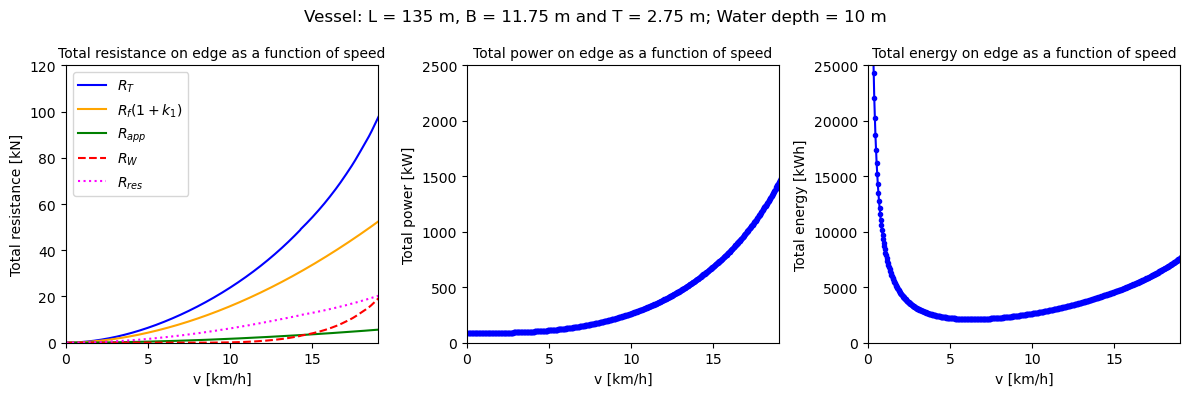

In [34]:
# Generate plot
fig, axes = plt.subplots(1,3,figsize=(12,4))

# plot resistance components as a function of vessel speed
axes[0].plot([i*3.6 for i in velocity_range], R_tot, '-',  c='blue', mfc='blue', mec='blue', markersize=3, label='$R_T$')
axes[0].plot([i*3.6 for i in velocity_range], R_f_one_k1, '-',  c='orange', mfc='orange', mec='orange', markersize=3, label='$R_f (1+k_1)$')
axes[0].plot([i*3.6 for i in velocity_range], R_APP, '-',  c='green', mfc='green', mec='green', markersize=3, label='$R_{app}$')
axes[0].plot([i*3.6 for i in velocity_range], R_W, '--',  c='red', mfc='red', mec='red', markersize=3, label='$R_W$')
axes[0].plot([i*3.6 for i in velocity_range], R_res, ':',  c='magenta', mfc='magenta', mec='magenta', markersize=3, label='$R_{res}$')

axes[0].axis([0,19,0,120])
axes[0].set_xlabel('v [km/h]');
axes[0].set_ylabel('Total resistance [kN]');
axes[0].set_title('Total resistance on edge as a function of speed', fontsize=10);
axes[0].legend(loc='upper left')
    
# plot total power needed to pass the edge as a function of vessel speed
axes[1].plot([i*3.6 for i in velocity_range], P_tot, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[1].axis([0,19,0,2500])
axes[1].set_xlabel('v [km/h]');
axes[1].set_ylabel('Total power [kW]');
axes[1].set_title('Total power on edge as a function of speed', fontsize=10);

# plot total energy needed to pass the edge as a function of vessel speed 
axes[2].plot([i*3.6 for i in velocity_range], total_energy, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[2].axis([0,19,0,25000])
axes[2].set_xlabel('v [km/h]');
axes[2].set_ylabel('Total energy [kWh]');
axes[2].set_title('Total energy on edge as a function of speed', fontsize=10);

# Add a super title
fig.suptitle("Vessel: L = {} m, B = {} m and T = {} m; Water depth = {} m".format(vessels[0].L, vessels[0].B, vessels[0].T, vessels[0].env.graph.edges[('0','1')]['Info']['GeneralDepth']), fontsize=12)

# Adjust layout to bring the title closer to the plots
fig.tight_layout(rect=[0, 0, 1, 1])  # Adjust the top margin (last value)

plt.show()

Panel 1 in the figure above, corresponds to Part IV - Figure 5.4 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004. Panel 2 shows how the R_tot from Panel 1 is converted to P_tot, multiplying with v and using various efficiency factors. Panel 3 shows the total energy that is required to pass the 100 km long edge. This total energy is derived by multiplying the P_tot with the time it takes to pass the edge. For very low v's the R_tot is low, but it also takes long to pass the edge. For high v's the R_tot escalates, but the time to pass the edge reduces.

#### 4.2 Show the effects of vessel velocity on emissions
We use the results from the previous section to show the effects of vessel velocities on emissions.

In [35]:
# collect values to plot
total_CO2=[]
total_NOx=[]
total_PM10=[]
for index, df in enumerate(dfs):
    total_CO2.append(df.CO2_g_per_km.values[0])
    total_NOx.append(df.NOx_g_per_km.values[0])
    total_PM10.append(df.PM10_g_per_km.values[0])

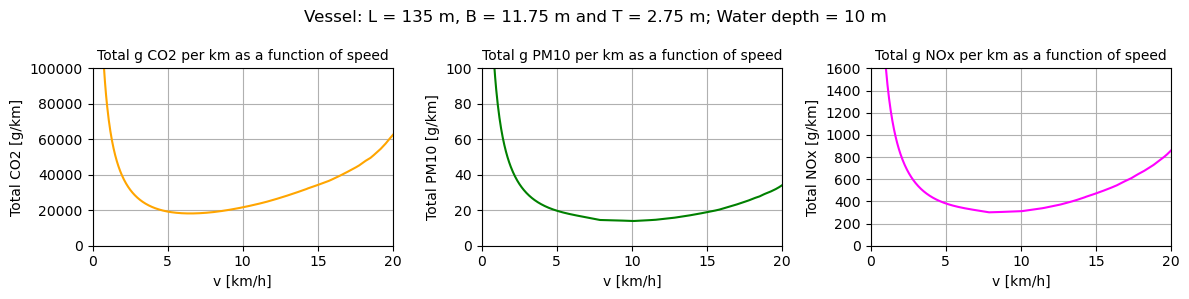

In [36]:
fig, axes = plt.subplots(1,3,figsize=(12,3))

# plot the g CO2 per km as a function of vessel speed 
axes[0].plot([i*3.6 for i in velocity_range], total_CO2, '-',  c='orange')

axes[0].set_xlabel('v [km/h]');
axes[0].set_ylabel('Total CO2 [g/km]');
axes[0].set_title('Total g CO2 per km as a function of speed', fontsize=10);
axes[0].axis([0,20,0,100000])
axes[0].grid(visible=True)

# plot the g PM10 per km as a function of vessel speed 
axes[1].plot([i*3.6 for i in velocity_range], total_PM10, '-',  c='green')

axes[1].set_xlabel('v [km/h]');
axes[1].set_ylabel('Total PM10 [g/km]');
axes[1].set_title('Total g PM10 per km as a function of speed', fontsize=10);
axes[1].axis([0,20,0,100])
axes[1].grid(visible=True)

# plot the g NOx per km as a function of vessel speed 
axes[2].plot([i*3.6 for i in velocity_range], total_NOx, '-',  c='magenta')


axes[2].set_xlabel('v [km/h]');
axes[2].set_ylabel('Total NOx [g/km]');
axes[2].set_title('Total g NOx per km as a function of speed', fontsize=10);
axes[2].axis([0,20,0,1600])
axes[2].set_yticks((0, 200, 400, 600, 800, 1000, 1200, 1400, 1600))
axes[2].set_yticklabels(('0', '200', '400', '600', '800', '1000', '1200', '1400', '1600'))
axes[2].grid(visible=True)

# Add a super title
fig.suptitle("Vessel: L = {} m, B = {} m and T = {} m; Water depth = {} m".format(vessels[0].L, vessels[0].B, vessels[0].T, vessels[0].env.graph.edges[('0','1')]['Info']['GeneralDepth']), fontsize=12)

fig.tight_layout()

The above figure, corresponds to Part IV - Figure 5.10 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004. Panel 1 shows g/km emission of CO2 (the total CO2 emitted while passing the 100 km edge, divided by the length of the edge). Panel 2 shows the g/km emission of PM10. Panel 3 shows the g/km emission of NOx. The y-axes indicate emissions in g/km. The shape of the graph shows that for low speeds inefficient engine use combined with longer dwell time leads to higher emissions per unit distance. For higher speeds the increased resistance leads to higher emissions per unit distance. An optimum lies in between.

#### 4.3 Show the effects of increasing engine power on vessel speed and emissions
We will now sail the same path with the same vessel at a given speed, and change the water depths in steps.

In [37]:
# generate a range of Power_given values
P_tot_given_list = list(np.arange(100,2000,10))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []

for P_tot_given in P_tot_given_list:
    # execute predefined mission
    df, vessel = mission(FG=FG,
                         GeneralDepth=7.5,
                         name='Vessel',
                         origin='0', 
                         destination='1', 
                         vessel_type='inland vessel', 
                         L=135,                   # m
                         B=11.45,                 # m 
                         T=2.75,                  # m
                         v=None,                  # m/s None: calculate this value based on P_tot_given
                         safety_margin=0.2,       # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                         h_squat=False,           # if consider the ship squatting while moving, set to True, otherwise set to False
                         P_installed=1750,        # kW
                         P_tot_given=P_tot_given, # kW None: calculate this value based on speed
                         bulbous_bow=False,       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                         karpov_correction=True,
                         P_hotel_perc=0.05,       # 0: all power goes to propulsion
                         P_hotel=None,            # None: calculate P_hotel from percentage
                         x=2,                     # number of propellers 
                         C_B=0.85,                # - block coefficient 
                         L_w=3,                   # weight class of the ship
                         C_year=1990,             # engine construction yea
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0),
                        )
    
    dfs.append(df)
    vessels.append(vessel)


In [38]:
# collect values to plot
R_tot=[]
R_f_one_k1=[] 
R_APP=[]
R_W=[]
R_res=[]
P_tot=[]
total_energy=[]
velocity_range = []
v_power_given=[]
for index, df in enumerate(dfs):
    R_tot.append(vessels[index].R_tot)
    R_f_one_k1.append(vessels[index].R_f_one_k1)
    R_APP.append(vessels[index].R_APP)
    R_W.append(vessels[index].R_W)
    R_res.append(vessels[index].R_res)
    P_tot.append(df.P_tot.values[0])
    total_energy.append(df.total_energy.values[0])
    velocity_range.append(vessels[index].v)
    v_power_given.append(vessels[index].P_given)

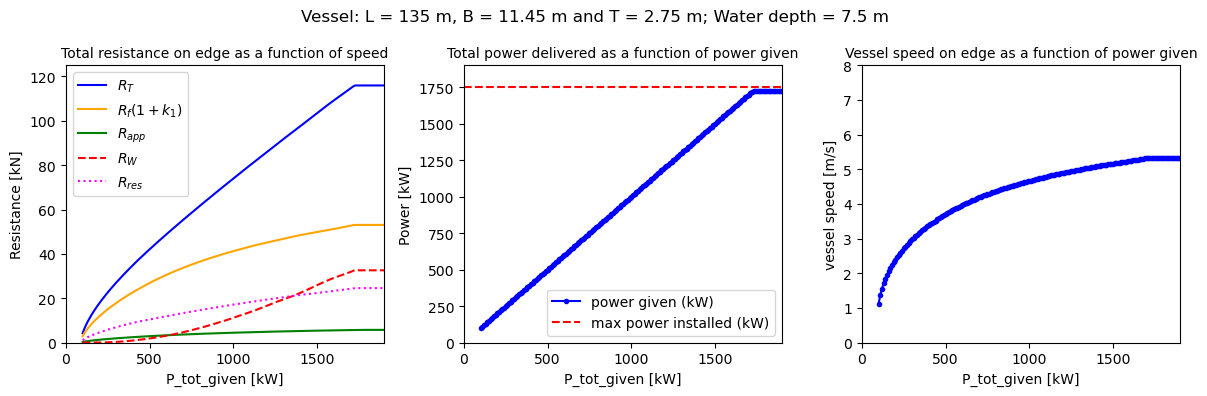

In [39]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

# plot resistance components as a function of vessel speed
axes[0].plot([i for i in P_tot_given_list], R_tot, '-',  c='blue', mfc='blue', mec='blue', markersize=3, label='$R_T$')
axes[0].plot([i for i in P_tot_given_list], R_f_one_k1, '-',  c='orange', mfc='orange', mec='orange', markersize=3, label='$R_f (1+k_1)$')
axes[0].plot([i for i in P_tot_given_list], R_APP, '-',  c='green', mfc='green', mec='green', markersize=3, label='$R_{app}$')
axes[0].plot([i for i in P_tot_given_list], R_W, '--',  c='red', mfc='red', mec='red', markersize=3, label='$R_W$')
axes[0].plot([i for i in P_tot_given_list], R_res, ':',  c='magenta', mfc='magenta', mec='magenta', markersize=3, label='$R_{res}$')

axes[0].axis([0,1900,0,125])
axes[0].set_xlabel('P_tot_given [kW]');
axes[0].set_ylabel('Resistance [kN]');
axes[0].set_title('Total resistance on edge as a function of speed', fontsize=10);
axes[0].legend(loc='upper left')
    
# plot total power needed to pass the edge as a function of vessel speed
# todo: something is still not right (I expect the P_tot_given and the P_tot to be equal ... that should be the target of the optimisation)
axes[1].plot([i for i in P_tot_given_list], v_power_given, '-o',  c='blue', mfc='blue', mec='blue', markersize=3, label='power given (kW)')
axes[1].plot([0,1900], [1750, 1750], '--r', label='max power installed (kW)')

axes[1].axis([0,1900,0,1900])
axes[1].set_xlabel('P_tot_given [kW]');
axes[1].set_ylabel('Power [kW]');
axes[1].set_title('Total power delivered as a function of power given', fontsize=10);
axes[1].legend(loc='lower right')

# plot total energy needed to pass the edge as a function of vessel speed 
axes[2].plot([i for i in P_tot_given_list], velocity_range, '-o',  c='blue', mfc='blue', mec='blue', markersize=3)

axes[2].axis([0,1900,0,8])
axes[2].set_xlabel('P_tot_given [kW]');
axes[2].set_ylabel('vessel speed [m/s]');
axes[2].set_title('Vessel speed on edge as a function of power given', fontsize=10);

# Add a super title
fig.suptitle("Vessel: L = {} m, B = {} m and T = {} m; Water depth = {} m".format(vessels[0].L, vessels[0].B, vessels[0].T, vessels[0].env.graph.edges[('0','1')]['Info']['GeneralDepth']), fontsize=12)

fig.tight_layout()

The above plot shows how resistance, speed and power needed vary as a function of P_tot_given. Where by specifying v you can theoretically sail faster than the engine allows, specifying P_tot_given restricts the maximum speed to that what can be achieved by the P_installed.

In [40]:
dfs[-1]

time_start                  time_stop   edge_start  \
0 2024-01-01 2024-01-01 05:12:13.628887  POINT (0 0)   

                      edge_stop        P_tot      P_given  P_installed  \
0  POINT (0.8983152841195217 0)  1723.785759  1723.785759         1750   

   total_energy  total_diesel_consumption_C_year_ICE_mass  \
0   8970.211858                              2.012916e+06   

   total_diesel_consumption_ICE_mass  ...  total_emission_PM10  \
0                       2.063234e+06  ...          3480.442201   

   total_emission_NOX   stationary  water depth  distance       delta_t  \
0        87881.165572  8970.211858          7.5  100000.0  18733.628887   

   fuel_kg_per_km  CO2_g_per_km  PM10_g_per_km  NOx_g_per_km  
0       20.632337  63864.320343      34.804422    878.811656  

[1 rows x 47 columns]

#### 4.4 Show the effects of changing water depth (WIP)
We will now sail the same path with the same vessel at a given speed, and change the water depths in steps. First with 'karpov_correction' set to False.

In [41]:
# generate a range of depths
depth_list = list(np.arange(4, 15, .1))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []

for depth in depth_list:

    # execute predefined mission
    df, vessel = mission(FG=FG,
                         GeneralDepth=depth,
                         name='Vessel',
                         origin='0', 
                         destination='1', 
                         vessel_type='inland vessel', 
                         L=85,                   # m
                         B=9.5,                  # m 
                         T=2.58,                   # m
                         v=3.91,                   # m/s None: calculate this value based on P_tot_given
                         safety_margin=0.2,       # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                         h_squat=False,           # if consider the ship squatting while moving, set to True, otherwise set to False
                         P_installed=1750,        # kW
                         P_tot_given=None,        # kW None: calculate this value based on speed
                         bulbous_bow=False,       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                         karpov_correction=False,
                         P_hotel_perc=0.05,       # 0: all power goes to propulsion
                         P_hotel=None,            # None: calculate P_hotel from percentage
                         x=2,                     # number of propellers 
                         C_B=0.85,                # - block coefficient 
                         L_w=3,                   # weight class of the ship
                         C_year=1990,             # engine construction yea
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0),
                        )

    dfs.append(df)
    vessels.append(vessel)


In [42]:
# collect values to plot
P_tot_values=[]
for index, df in enumerate(dfs):
    P_tot_values.append(df.P_tot.values[0])

# collect values to plot
R_tot_values=[]
for index, df in enumerate(dfs):
    R_tot_values.append(vessels[index].R_tot)

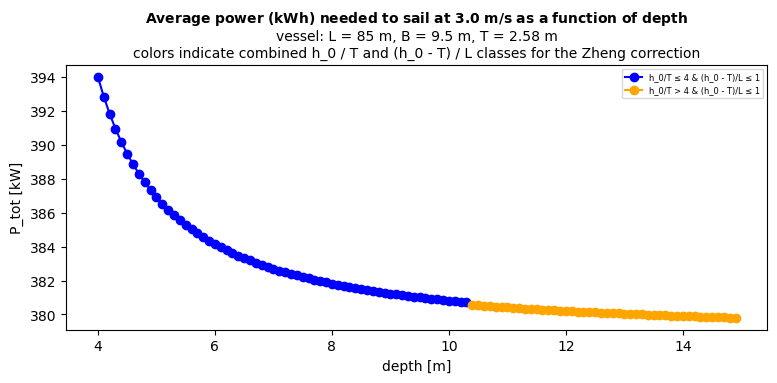

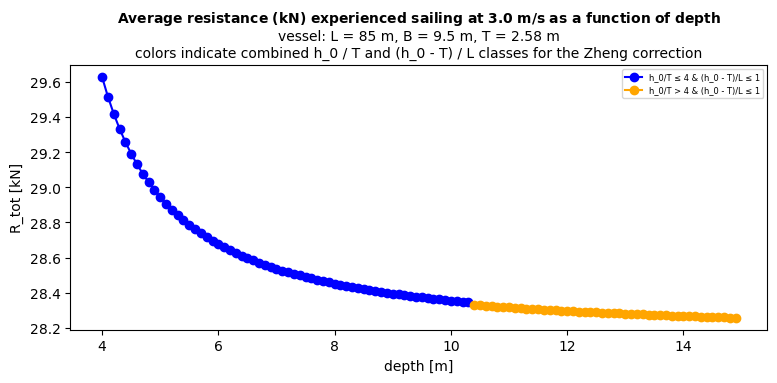

P_tot value for the largest depth 379.81 kW
R_tot value for the largest depth 28.26 kW


In [43]:
# Compute depth array and vessel parameters
depth_array = np.array(depth_list)
T = vessels[0].T
L = vessels[0].L

# Compute classification ratios
h_ratio = depth_array / T
ht_l_ratio = (depth_array - T) / L

# Define combined categories
categories = {
    'h_0/T ≤ 4 & (h_0 - T)/L ≤ 1': (h_ratio <= 4) & (ht_l_ratio <= 1),
    'h_0/T ≤ 4 & (h_0 - T)/L > 1': (h_ratio <= 4) & (ht_l_ratio > 1),
    'h_0/T > 4 & (h_0 - T)/L ≤ 1': (h_ratio > 4) & (ht_l_ratio <= 1),
    'h_0/T > 4 & (h_0 - T)/L > 1': (h_ratio > 4) & (ht_l_ratio > 1)
}

# Assign colors
colors = {
    'h_0/T ≤ 4 & (h_0 - T)/L ≤ 1': 'blue',
    'h_0/T ≤ 4 & (h_0 - T)/L > 1': 'green',
    'h_0/T > 4 & (h_0 - T)/L ≤ 1': 'orange',
    'h_0/T > 4 & (h_0 - T)/L > 1': 'red'
}

# --- Plot settings ---
fig_width_cm = 20
fig_height_cm = 10
fig_size_in = (fig_width_cm / 2.54, fig_height_cm / 2.54)

# --- Plot power ---
fig, ax = plt.subplots(figsize=fig_size_in)
for label, mask in categories.items():
    if np.any(mask):
        ax.plot(depth_array[mask], np.array(P_tot_values)[mask], 'o-', label=label, color=colors[label])
ax.set_xlabel('depth [m]')
ax.set_ylabel('P_tot [kW]')
title_line1 = r'$\mathbf{Average\ power\ (kWh)\ needed\ to\ sail\ at\ 3.0\ m/s\ as\ a\ function\ of\ depth}$'
title_line2 = f'vessel: L = {L} m, B = {vessels[0].B} m, T = {T} m'
title_line3 = 'colors indicate combined h_0 / T and (h_0 - T) / L classes for the Zheng correction'
ax.set_title(f'{title_line1}\n{title_line2}\n{title_line3}', fontsize=10)
ax.legend(fontsize=6)
plt.tight_layout()
plt.show()

# --- Plot resistance ---
fig, ax = plt.subplots(figsize=fig_size_in)
for label, mask in categories.items():
    if np.any(mask):
        ax.plot(depth_array[mask], np.array(R_tot_values)[mask], 'o-', label=label, color=colors[label])
ax.set_xlabel('depth [m]')
ax.set_ylabel('R_tot [kN]')
title_line1 = r'$\mathbf{Average\ resistance\ (kN)\ experienced\ sailing\ at\ 3.0\ m/s\ as\ a\ function\ of\ depth}$'
title_line2 = f'vessel: L = {L} m, B = {vessels[0].B} m, T = {T} m'
title_line3 = 'colors indicate combined h_0 / T and (h_0 - T) / L classes for the Zheng correction'
ax.set_title(f'{title_line1}\n{title_line2}\n{title_line3}', fontsize=10)
ax.legend(fontsize=6)
plt.tight_layout()
plt.show()

print('P_tot value for the largest depth {:.2f} kW'.format(P_tot_values[-1]))
print('R_tot value for the largest depth {:.2f} kW'.format(R_tot_values[-1]))

The correction by Zheng focuses on the friction resistance and involves two 'classes'. On the one hand a modified V_B that is used in the C_f calculation (where shallow is defined as h_0/T <= 4), and on the other a modified C_f (where shallow is defined as (h_0 - T)/L <= 1). The plot coloring shows in which part of the plot which conditions apply. Going from one condition to the next produces a small discontinuity

Now with 'karpov_correction' set to True.

In [44]:
# generate a range of depths
depth_list = list(np.arange(4, 15, .1))

# generate vessels that sail the edge for the given range of vessel speeds
dfs = []
vessels = []

for depth in depth_list:

    # execute predefined mission
    df, vessel = mission(FG=FG,
                         GeneralDepth=depth,
                         name='Vessel',
                         origin='0', 
                         destination='1', 
                         vessel_type='inland vessel', 
                         L=85,                    # m
                         B=9.5,                   # m 
                         T=2.58,                  # m
                         v=3.91,                  # m/s None: calculate this value based on P_tot_given
                         safety_margin=0.2,       # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                         h_squat=False,           # if consider the ship squatting while moving, set to True, otherwise set to False
                         P_installed=1750,        # kW
                         P_tot_given=None,        # kW None: calculate this value based on speed
                         bulbous_bow=False,       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                         karpov_correction=True,
                         P_hotel_perc=0.05,       # 0: all power goes to propulsion
                         P_hotel=None,            # None: calculate P_hotel from percentage
                         x=2,                     # number of propellers 
                         C_B=0.85,                # - block coefficient 
                         L_w=3,                   # weight class of the ship
                         C_year=1990,             # engine construction yea
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0),
                        )

    dfs.append(df)
    vessels.append(vessel)


In [45]:
# collect values to plot
P_tot_values=[]
for index, df in enumerate(dfs):
    P_tot_values.append(df.P_tot.values[0])

# collect values to plot
R_tot_values=[]
for index, df in enumerate(dfs):
    R_tot_values.append(vessels[index].R_tot)

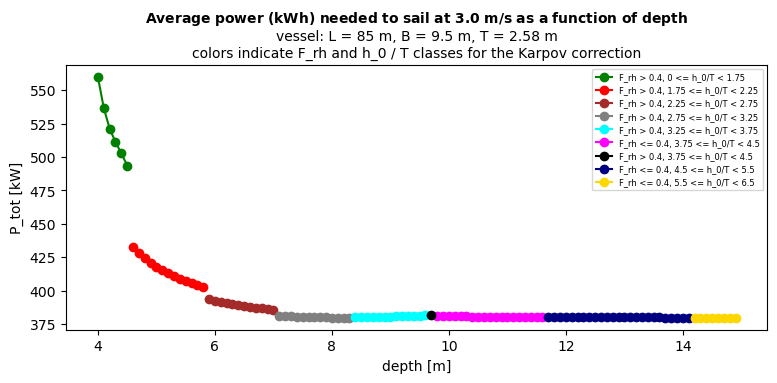

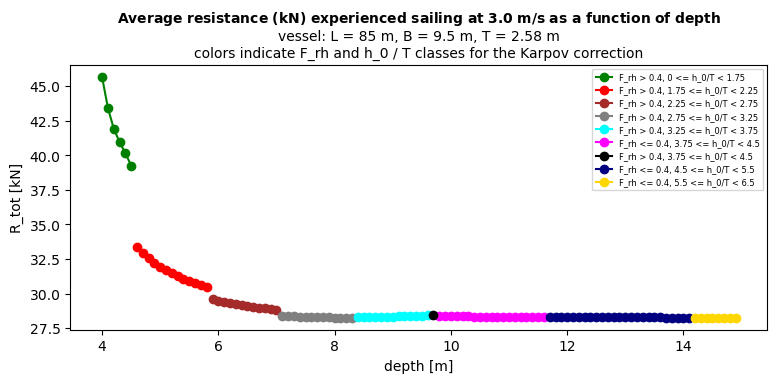

P_tot value for the largest depth 379.81 kW
R_tot value for the largest depth 28.26 kW


In [46]:
# Compute F_rh and h_ratio
depth_array = np.array(depth_list)
F_rh = vessels[0].v / np.sqrt(vessels[0].g * depth_array)
T = vessels[0].T
h_ratio = depth_array / T

# Define categories and colors
categories = {}
color_list = [
    'blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink',
    'gray', 'olive', 'cyan', 'magenta', 'black', 'navy', 'lime', 'gold', 'teal',
    'coral', 'orchid', 'maroon', 'turquoise', 'darkgreen', 'darkred', 'slateblue', 'peru'
]
colors = {}
color_index = 0

# Define h_0/T bins
h_bins = [
    (0, 1.75), (1.75, 2.25), (2.25, 2.75), (2.75, 3.25), (3.25, 3.75),
    (3.75, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5),
    (8.5, 9.5), (9.5, np.inf)
]

for h_min, h_max in h_bins:
    for frh_cond in ['<= 0.4', '> 0.4']:
        label = f'F_rh {frh_cond}, {h_min} <= h_0/T < {h_max}'
        if frh_cond == '<= 0.4':
            mask = (h_ratio >= h_min) & (h_ratio < h_max) & (F_rh <= 0.4)
        else:
            mask = (h_ratio >= h_min) & (h_ratio < h_max) & (F_rh > 0.4)
        categories[label] = mask
        colors[label] = color_list[color_index % len(color_list)]
        color_index += 1

# --- Plot ---
fig_width_cm = 20
fig_height_cm = 10
fig_size_in = (fig_width_cm / 2.54, fig_height_cm / 2.54)

# --- Plot power ---
fig, ax = plt.subplots(figsize=fig_size_in)
for label, mask in categories.items():
    if np.any(mask):
        ax.plot(depth_array[mask], np.array(P_tot_values)[mask], 'o-', label=label, color=colors[label])
ax.set_xlabel('depth [m]')
ax.set_ylabel('P_tot [kW]')
title_line1 = r'$\mathbf{Average\ power\ (kWh)\ needed\ to\ sail\ at\ 3.0\ m/s\ as\ a\ function\ of\ depth}$'
title_line2 = f'vessel: L = {vessels[0].L} m, B = {vessels[0].B} m, T = {vessels[0].T} m'
title_line3 = 'colors indicate F_rh and h_0 / T classes for the Karpov correction'
ax.set_title(f'{title_line1}\n{title_line2}\n{title_line3}', fontsize=10)
ax.legend(fontsize=6)
plt.tight_layout()
plt.show()

# --- Plot resistance ---
fig, ax = plt.subplots(figsize=fig_size_in)
for label, mask in categories.items():
    if np.any(mask):
        ax.plot(depth_array[mask], np.array(R_tot_values)[mask], 'o-', label=label, color=colors[label])
ax.set_xlabel('depth [m]')
ax.set_ylabel('R_tot [kN]')
title_line1 = r'$\mathbf{Average\ resistance\ (kN)\ experienced\ sailing\ at\ 3.0\ m/s\ as\ a\ function\ of\ depth}$'
title_line2 = f'vessel: L = {vessels[0].L} m, B = {vessels[0].B} m, T = {vessels[0].T} m'
title_line3 = 'colors indicate F_rh and h_0 / T classes for the Karpov correction'
ax.set_title(f'{title_line1}\n{title_line2}\n{title_line3}', fontsize=10)
ax.legend(fontsize=6)
plt.tight_layout()
plt.show()

print('P_tot value for the largest depth {:.2f} kW'.format(P_tot_values[-1]))
print('R_tot value for the largest depth {:.2f} kW'.format(R_tot_values[-1]))

The results show that while applying the Karpov correction factors, for deep water the estimated values for P_tot and R_tot are exactly the same. For shallower water the Karpov correction keeps the P_tot and R_tot value to similar values as the deeper water at first. But when the shallow water effects start to play a role, both the P_tot and R_tot values start to rise more quickly, and also to substantially higher values.